# Benchmarking Autoregressive Conditional Diffusion Models for Turbulent Flow Simulation

This notebook contains a simple example to train and evaluate autoregressive conditional diffusion models ([ACDM](https://github.com/tum-pbs/autoreg-pde-diffusion)), following our [paper](https://arxiv.org/abs/2309.01745). The problem setting is the creation of a diffusion-based architecture, that can probabilistically predict the next simulation step of a turbulent flow simulation.

As a first step, we download and extract a small toy dataset containing a sequence from the transonic flow data set $\texttt{Tra}$ with mach number $\textit{Ma} = 0.7$. Furthermore, a pre-trained model checkpoint is downloaded. This might take a few minutes. (Note: the commands will not re-download files, if already downloaded successfully)

In [1]:
# history -g -f filename

In [2]:
!wget -nc "https://dataserv.ub.tum.de/s/m1734798.001/download?path=/&files=128_tra_small.zip" -O data/128_tra_small.zip --no-check-certificate 
!unzip -nq data/128_tra_small.zip -d data
!wget -nc "https://dataserv.ub.tum.de/s/m1734798.001/download?path=/&files=checkpoints_acdm_tra.zip" -O models/checkpoints_acdm_tra.zip --no-check-certificate 
!unzip -nq models/checkpoints_acdm_tra.zip -d models

File ‘data/128_tra_small.zip’ already there; not retrieving.


File ‘models/checkpoints_acdm_tra.zip’ already there; not retrieving.


Colab already comes with a range of pre-installed packages and we only need to additionally install the *einops* package. If you are running this file locally and not inside colab, follow the [installation instructions for ACDM](https://github.com/tum-pbs/autoreg-pde-diffusion) to install required packages before continuing instead.

In [3]:
try:
    import google.colab  # only to ensure that we are inside colab
    !pip install einops
except ImportError:
    print("This notebook is running locally, please follow the ACDM installation instructions first, then continue with the cell below.")
    pass

This notebook is running locally, please follow the ACDM installation instructions first, then continue with the cell below.


Lets import some packages that we will need in the follwing.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SequentialSampler, RandomSampler

from einops import rearrange
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

import math
import os, json
from typing import List,Tuple,Dict


## Data Handling and Loading

Next, we prepare a class to handle and load the downloaded data set, as well as a data transformations class to handle the data normalization. Mean and standard deviation values are precomputed constants for any given data set.

In [5]:
class TurbulenceDataset(Dataset):
    """Data set for turbulence and wavelet noise data

    Args:
        name: name of the dataset
        dataDirs: list of paths to data directories
        filterTop: filter for top level folder names (e.g. different types of data)
        excludeFilterTop: mode for filterTop (exclude or include)
        filterSim: filter simulations by min and max (min inclusive, max exclusive)
        excludefilterSim: mode for filterSim (exclude or include)
        filterFrame: mandatory filter for simulation frames by min and max (min inclusive, max exclusive)
        sequenceLength: number of frames to group into a sequence and number of frames to omit in between
        randSeqOffset: randomizes the starting frame of each sequence
        simFields: list of simulation fields to include (vel is always included) ["dens", "pres"]
        simParams: list of simulation parameters to include ["rey", "mach"]
        printLevel: print mode for contents of the dataset ["none", "top", "sim", "full"]
    """

    def __init__(self, name:str, dataDirs:List[str], filterTop:List[str], excludeFilterTop:bool=False, filterSim:List[Tuple[int, int]]=[],
                excludefilterSim:bool=False, filterFrame:List[Tuple[int, int]]=[], sequenceLength:List[Tuple[int, int]]=[],
                randSeqOffset:bool=False, simFields:List[str]=[], simParams:List[str]=[], printLevel:str="none"):

        self.transform = None
        self.name = name
        self.dataDirs = dataDirs
        self.filterTop = filterTop
        self.excludeFilterTop = excludeFilterTop
        self.filterSim = filterSim
        self.excludefilterSim = excludefilterSim
        self.filterFrame = filterFrame
        self.sequenceLength = sequenceLength
        self.randSeqOffset = randSeqOffset
        self.simFields = ["velocity"]
        if "dens" in simFields:
            self.simFields += ["density"]
        if "pres" in simFields:
            self.simFields += ["pressure"]

        self.simParams = simParams
        self.printLevel = printLevel

        self.summaryPrint = []
        self.summaryPrint += ["Dataset " + name + " at " + str(dataDirs)]
        self.summaryPrint += [self.getFilterInfoString()]

        # BUILD FULL FILE LIST
        self.dataPaths = []
        self.dataPathModes = []

        for dataDir in dataDirs:
            topDirs = os.listdir(dataDir)
            topDirs.sort()

            # top level folders
            for topDir in topDirs:
                if filterTop:
                    # continue when excluding or including according to filter
                    if excludeFilterTop == any( item in topDir for item in filterTop ):
                        continue

                match = -1
                # compute matching top filter for according sim or frame filtering
                if len(filterSim) > 1 or len(filterFrame) > 1:
                    for i in range(len(filterTop)):
                        if filterTop[i] in topDir:
                            match = i
                            break
                    assert (match >= 0), "Match computation error"

                simDir = os.path.join(dataDir, topDir)
                sims = os.listdir(simDir)
                sims.sort()

                if printLevel == "top":
                    self.summaryPrint += ["Top folder loaded: " + simDir.replace(dataDir + "/", "")]

                # sim_000001 folders
                for sim in sims:
                    currentDir = os.path.join(simDir, sim)
                    if not os.path.isdir(currentDir):
                        continue

                    if len(filterSim) > 0:
                        simNum = int(sim.split("_")[1])
                        if len(filterSim) == 1:
                            if type(filterSim[0]) is tuple:
                                inside = simNum >= filterSim[0][0] and simNum < filterSim[0][1]
                            elif type(filterSim[0]) is list:
                                inside = simNum in filterSim[0]
                        else:
                            if type(filterSim[match]) is tuple:
                                inside = simNum >= filterSim[match][0] and simNum < filterSim[match][1]
                            elif type(filterSim[match]) is list:
                                inside = simNum in filterSim[match]
                        # continue when excluding or including according to filter
                        if inside == excludefilterSim:
                            continue

                    if printLevel == "sim":
                        self.summaryPrint += ["Sim loaded: " + currentDir.replace(dataDir + "/", "")]

                    # individual simulation frames
                    minFrame = filterFrame[0][0] if len(filterFrame) == 1 else filterFrame[match][0]
                    maxFrame = filterFrame[0][1] if len(filterFrame) == 1 else filterFrame[match][1]
                    seqLength = sequenceLength[0][0] if len(sequenceLength) == 1 else sequenceLength[match][0]
                    seqSkip   = sequenceLength[0][1] if len(sequenceLength) == 1 else sequenceLength[match][1]
                    for seqStart in range(minFrame, maxFrame, seqLength*seqSkip):
                        validSeq = True
                        for frame in range(seqStart, seqStart+seqLength*seqSkip, seqSkip):
                            # discard incomplete sequences at simulation end
                            if seqStart+seqLength*seqSkip > maxFrame:
                                validSeq = False
                                break

                            for field in self.simFields:
                                currentField = os.path.join(currentDir, "%s_%06d.npz" % (field, frame))
                                if not os.path.isfile(currentField):
                                    raise FileNotFoundError("Could not load %s file: %s" % (field, currentField))

                        # imcomplete sequence means there are no more frames left
                        if not validSeq:
                            break

                        if printLevel == "full":
                            self.summaryPrint += ["Frames %s loaded: %s/%s_%06d-%06d(%03d).npz" % ("-".join(self.simFields),
                                        currentDir.replace(dataDir + "/", ""), "-".join(self.simFields), seqStart, seqStart + seqLength*(seqSkip-1), seqSkip)]

                        self.dataPaths.append((currentDir, seqStart, seqStart + seqLength*seqSkip, seqSkip))

        self.summaryPrint += ["Dataset Length: %d\n" % len(self.dataPaths)]


    def __len__(self) -> int:
        return len(self.dataPaths)


    def __getitem__(self, idx:int) -> dict:
        # sequence indexing
        basePath, seqStart, seqEnd, seqSkip = self.dataPaths[idx]
        seqLen = int((seqEnd - seqStart) / seqSkip)
        if self.randSeqOffset:
            halfSeq = int((seqEnd-seqStart) / 2)
            offset = torch.randint(-halfSeq, halfSeq+1, (1,)).item()
            if seqStart + offset >= self.filterFrame[0][0] and seqEnd + offset < self.filterFrame[0][1]:
                seqStart = seqStart + offset
                seqEnd = seqEnd + offset

        # loading simulation parameters
        with open(os.path.join(basePath, "src", "description.json")) as f:
            loadedJSON = json.load(f)

            loadNames = ["Reynolds Number", "Mach Number", "Drag Coefficient", "Lift Coefficient", "Z Slice"]
            loadedParams = {}
            for loadName in loadNames:
                loadedParam = np.zeros(seqLen, dtype=np.float32)
                if loadName in loadedJSON:
                    temp = loadedJSON[loadName]
                    if isinstance(temp, int) or isinstance(temp, float):
                        temp = np.array(temp, dtype=np.float32)
                        loadedParam[0:] = np.repeat(temp, seqLen)
                    elif isinstance(temp, list):
                        loadedParam[0:] = temp[seqStart:seqEnd:seqSkip]
                    else:
                        raise ValueError("Invalid simulation parameter data type")
                loadedParams[loadName] = loadedParam

            if "rey" in self.simParams and "mach" in self.simParams:
                simParameters = np.stack([loadedParams["Reynolds Number"], loadedParams["Mach Number"]], axis=1)
            elif "rey" in self.simParams:
                simParameters = np.reshape(loadedParams["Reynolds Number"], (-1,1))
            elif "mach" in self.simParams:
                simParameters = np.reshape(loadedParams["Mach Number"], (-1,1))
            elif "zslice" in self.simParams:
                simParameters = np.reshape(loadedParams["Z Slice"], (-1,1))
            elif not self.simParams:
                simParameters ={}
            else:
                raise ValueError("Invalid specification of simulation parameters")

        # loading obstacle mask
        if os.path.isfile(os.path.join(basePath, "obstacle_mask.npz")):
            obsMask = np.load(os.path.join(basePath, "obstacle_mask.npz"))['arr_0']
        else:
            obsMask = None

        # loading fields and combining them with simulation parameters
        loaded = {}
        for field in self.simFields:
            loaded[field] = []

        for frame in range(seqStart, seqEnd, seqSkip):
            for field in self.simFields:
                loadedArr = np.load(os.path.join(basePath, "%s_%06d.npz" % (field,frame)))['arr_0']
                loaded[field] += [loadedArr.astype(np.float32)]

        loadedFields = []
        for field in self.simFields:
            loadedFields += [np.stack(loaded[field], axis=0)]

        if type(simParameters) is not dict:
            vel = loadedFields[0]
            if vel.ndim == 4:
                simParExpanded = simParameters[:,:,np.newaxis,np.newaxis]
                simParExpanded = np.repeat(np.repeat(simParExpanded, vel.shape[2], axis=2), vel.shape[3], axis=3)
            elif vel.ndim == 5:
                simParExpanded = simParameters[:,:,np.newaxis,np.newaxis,np.newaxis]
                simParExpanded = np.repeat(np.repeat(np.repeat(simParExpanded, vel.shape[2], axis=2), vel.shape[3], axis=3), vel.shape[4], axis=4)
            else:
                raise ValueError("Invalid input shape when loading samples!")
            loadedFields += [simParExpanded]

        data = np.concatenate(loadedFields, axis=1) # ORDER (fields): velocity (x,y), velocity z / density, pressure, ORDER (params): rey, mach, zslice

        # output
        dataPath = "%s/%s_%06d-%06d(%03d).npz" % (basePath, "-".join(self.simFields), seqStart, seqEnd - seqSkip, seqSkip)
        sample = {"data" : data, "simParameters" : simParameters, "allParameters" : loadedParams, "path" : dataPath}
        if obsMask is not None:
            sample["obsMask"] = obsMask

        if self.transform:
            sample = self.transform(sample)
        else:
            print("WARNING: no data transformations are employed!")

        return sample


    def printDatasetInfo(self):
        if self.transform:
            s  = "%s - Data Normalization Transformation: ACTIVE\n" % (self.name)
            self.summaryPrint += [s]
        print('\n'.join(self.summaryPrint))

    def getFilterInfoString(self) -> str:
        s  = "%s - Data Filter Setup: \n" % (self.name)
        s += "\tdataDirs: %s\n" % (str(self.dataDirs))
        s += "\tfilterTop: %s  exlude: %s\n" % (str(self.filterTop), self.excludeFilterTop)
        s += "\tfilterSim: %s  exlude: %s\n" % (str(self.filterSim), self.excludefilterSim)
        s += "\tfilterFrame: %s\n" % (str(self.filterFrame))
        s += "\tsequenceLength: %s\n" % (str(self.sequenceLength))
        return s


In [6]:
class DataTransforms(object):

    def __init__(self, normalizeMode="traMixed", simFields=["dens","pres"], simParams=["mach"]):
        self.simFields = simFields
        self.simParams = simParams

        # mean and std statistics from whole dataset for normalization
        if "tra" in normalizeMode.lower() and "mixed" in normalizeMode.lower():
            # ORDER (fields): velocity (x,y), density, pressure, ORDER (params): rey, mach
            self.normMean = np.array([0.560642, -0.000129, 0.903352, 0.637941, 10000.000000, 0.700000], dtype=np.float32)
            self.normStd =  np.array([0.216987, 0.216987, 0.145391, 0.119944, 1, 0.118322], dtype=np.float32)


    def __call__(self, sample:dict):
        data = sample["data"]
        simParameters = sample["simParameters"]
        allParameters = sample["allParameters"]
        obsMask = sample.get("obsMask", None)
        path = sample["path"]

        # normalization to std. normal distr. with zero mean and unit std via statistics from whole dataset
        # ORDER (fields): velocity (x,y), velocity z / density, pressure, ORDER (params): rey, mach
        filterList = [0, 1]
        if "dens" in self.simFields:
            filterList += [2]
        if "pres" in self.simFields:
            filterList += [3]
        if "rey" in self.simParams:
            filterList += [4]
        if "mach" in self.simParams:
            filterList += [5]
        filterArr = np.array(filterList)
        filterArrParam = filterArr[-len(self.simParams):]

        if self.simParams:
            meanParam = self.normMean[filterArrParam].reshape((1,-1))
            stdParam = self.normStd[filterArrParam].reshape((1,-1))
            simParameters = (simParameters - meanParam) / stdParam

        meanData = self.normMean[filterArr].reshape((1,-1,1,1))
        stdData = self.normStd[filterArr].reshape((1,-1,1,1))
        data = (data - meanData) / stdData

        # toTensor
        result = torch.from_numpy(data)
        if obsMask is not None:
            obsMask = torch.from_numpy(obsMask)

        outDict = {"data": result, "simParameters": simParameters, "allParameters": allParameters, "path": path}
        if obsMask is not None:
            outDict["obsMask"] = obsMask
        return outDict

## Backbone Model Definition

Of course, we will also need a neural network architecture. Here, we will rely on a ["modern" U-Net](https://arxiv.org/abs/2006.11239), built from a range of individual layers including different attention mechanisms. This architecture is the backbone of the diffusion model and can be switched with other CNN archtitectures as well.

We start with a residual block that defines the skip connections, as well as the up- and downsampling operation of the U-Net. We will also make use of sinusoidal position embeddings from the [transformer architecture](https://arxiv.org/abs/1706.03762), to integrate the diffusion step with a time embedding MLP throught the U-Net layers.

In [7]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

Next, this class is the core convolution block in every level of the U-Net architecture, based on the [ConvNeXtBlock](https://arxiv.org/abs/2201.03545).

In [8]:
class ConvNextBlock(nn.Module):

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if time_emb_dim is not None else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if self.mlp is not None and time_emb is not None:
            assert time_emb is not None, "time embedding must be passed in"
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)

The modernized U-Net also comes with different attention layers spread across its blocks, so here two more classes following the [transformer architecture](https://arxiv.org/abs/1706.03762).

In [9]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = torch.einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = torch.einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

Putting the introduced layers together, here is the backbone U-Net:

In [10]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)


class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = init_dim if init_dim is not None else dim // 3 * 2
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            raise NotImplementedError()

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )

        else:
            time_dim = None
            self.time_mlp = None
            self.cond_mlp = None
            self.sim_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = out_dim if out_dim is not None else channels
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if self.time_mlp is not None else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

## Variance Schedule

To determine the noise levels over the course of the diffusion process, a noise schedule is required. Here, we will employ the simple linear schedule proposed by [Ho et al.](https://arxiv.org/abs/2006.11239), with adjusted variance parameters, such that any number of diffusion steps larger than 10 should work well:

In [11]:
def linear_beta_schedule(timesteps):
    if timesteps < 10:
        raise ValueError("Warning: Less than 10 timesteps require adjustments to this schedule!")

    beta_start = 0.0001 * (500/timesteps) # adjust reference values determined for 500 steps
    beta_end = 0.02 * (500/timesteps)
    betas = torch.linspace(beta_start, beta_end, timesteps)
    return torch.clip(betas, 0.0001, 0.9999)

## Diffusion Model Definition

Finally, we have collected all pieces to define a class containing the actual diffusion model.

In [12]:
class DiffusionModel(nn.Module):
    def __init__(self, diffusionSteps:int, condChannels:int, dataChannels:int):
        super(DiffusionModel, self).__init__()

        self.timesteps = diffusionSteps
        betas = linear_beta_schedule(timesteps=self.timesteps)

        betas = betas.unsqueeze(1).unsqueeze(2).unsqueeze(3)
        alphas = 1.0 - betas
        alphasCumprod = torch.cumprod(alphas, axis=0)
        alphasCumprodPrev = F.pad(alphasCumprod[:-1], (0,0,0,0,0,0,1,0), value=1.0)
        sqrtRecipAlphas = torch.sqrt(1.0 / alphas)

        # calculations for diffusion q(x_t | x_{t-1}) and others
        sqrtAlphasCumprod = torch.sqrt(alphasCumprod)
        sqrtOneMinusAlphasCumprod = torch.sqrt(1. - alphasCumprod)

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        posteriorVariance = betas * (1. - alphasCumprodPrev) / (1. - alphasCumprod)
        sqrtPosteriorVariance = torch.sqrt(posteriorVariance)

        self.register_buffer("betas", betas)
        self.register_buffer("sqrtRecipAlphas", sqrtRecipAlphas)
        self.register_buffer("sqrtAlphasCumprod", sqrtAlphasCumprod)
        self.register_buffer("sqrtOneMinusAlphasCumprod", sqrtOneMinusAlphasCumprod)
        self.register_buffer("sqrtPosteriorVariance", sqrtPosteriorVariance)

        # backbone model
        self.unet = Unet(
            dim=128,
            channels= condChannels + dataChannels,
            dim_mults=(1,1,1),
            use_convnext=True,
            convnext_mult=1,
        )


    # input shape (both inputs): B S C W H (D) -> output shape (both outputs): B S nC W H (D)
    def forward(self, conditioning:torch.Tensor, data:torch.Tensor) -> torch.Tensor:
        device = "cuda" if data.is_cuda else "cpu"
        seqLen = data.shape[1]

        # combine batch and sequence dimension for decoder processing
        d = torch.reshape(data, (-1, data.shape[2], data.shape[3], data.shape[4]))
        cond = torch.reshape(conditioning, (-1, conditioning.shape[2], conditioning.shape[3], conditioning.shape[4]))

        # TRAINING
        if self.training:

            # forward diffusion process that adds noise to data
            d = torch.concat((cond, d), dim=1)
            noise = torch.randn_like(d, device=device)
            t = torch.randint(0, self.timesteps, (d.shape[0],), device=device).long()
            dNoisy = self.sqrtAlphasCumprod[t] * d + self.sqrtOneMinusAlphasCumprod[t] * noise

            # noise prediction with network
            predictedNoise = self.unet(dNoisy, t)

            # unstack batch and sequence dimension again
            noise = torch.reshape(noise, (-1, seqLen, conditioning.shape[2] + data.shape[2], data.shape[3], data.shape[4]))
            predictedNoise = torch.reshape(predictedNoise, (-1, seqLen, conditioning.shape[2] + data.shape[2], data.shape[3], data.shape[4]))

            return noise, predictedNoise


        # INFERENCE
        else:
            # conditioned reverse diffusion process
            dNoise = torch.randn_like(d, device=device)
            cNoise = torch.randn_like(cond, device=device)

            for i in reversed(range(0, self.timesteps)):
                t = i * torch.ones(cond.shape[0], device=device).long()

                # compute conditioned part with normal forward diffusion
                condNoisy = self.sqrtAlphasCumprod[t] * cond + self.sqrtOneMinusAlphasCumprod[t] * cNoise

                dNoiseCond = torch.concat((condNoisy, dNoise), dim=1)

                # backward diffusion process that removes noise to create data
                predictedNoiseCond = self.unet(dNoiseCond, t)

                # use model (noise predictor) to predict mean
                modelMean = self.sqrtRecipAlphas[t] * (dNoiseCond - self.betas[t] * predictedNoiseCond / self.sqrtOneMinusAlphasCumprod[t])

                dNoise = modelMean[:, cond.shape[1]:modelMean.shape[1]] # discard prediction of conditioning
                if i != 0:
                    # sample randomly (only for non-final prediction), use mean directly for final prediction
                    dNoise = dNoise + self.sqrtPosteriorVariance[t] * torch.randn_like(dNoise)

            # unstack batch and sequence dimension again
            dNoise = torch.reshape(dNoise, (-1, seqLen, data.shape[2], data.shape[3], data.shape[4]))

            return dNoise

## Training

With all these building blocks out of the way, now its time put them together and train the diffusion model. You can choose to either continue training for a few epochs from the provided model checkpoint (takes less than a minute for 10 epochs), or train the model from scratch on the small examplary data set (takes about half an hour for 1000 epochs). Note that the prediction quality and diversity for training the model from scratch will be noticeably worse, due to limited amount of data available here.

Feel free to skip this step entirely, if you don't want to train the network. You can directly continue with the sampling below, by using the pre-trained checkpoint.

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Training device: %s" % device)

startFromCheckpoint = False

batch = 16 # training batch size
if startFromCheckpoint:
    epochs = 100 # finetune only for a small number of epochs
    # epochs = 0
    lr = 0.00001 # since the model is already trained, a conservatively low learning rate
else:
    # epochs = 10000 # train from scratch for large number of epochs
    epochs = 10000 # train from scratch for large number of epochs
    lr = 0.0001 # larger learning rate for training from scratch

sequenceLength = [3,2] # three timesteps (two input steps and one target step) with a temporal stride of 2
simFields = ["dens", "pres"] # the provided data set contains velocity (implict), as well as density and pressure values
simParams = ["mach"] # scalar simulation parameters on which the model is conditioned only contain the Mach number here
diffusionSteps = 20 # the provided model checkpoint was pretrained on 20 diffusion steps

# data set and data loading
trainSet = TurbulenceDataset("Training", ["data"], filterTop=["128_small_tra"], filterSim=[[0]], excludefilterSim=False, filterFrame=[(250,1000)],
                sequenceLength=[sequenceLength], randSeqOffset=True, simFields=simFields, simParams=simParams, printLevel="sim")
trainSet.transform = DataTransforms(normalizeMode="traMixed", simFields=simFields, simParams=simParams)
trainSet.printDatasetInfo()
trainSampler = RandomSampler(trainSet)
#trainSampler = SequentialSampler(trainSet)
trainLoader = DataLoader(trainSet, sampler=trainSampler, batch_size=batch, drop_last=True, num_workers=2)

# model definition
condChannels = 2 * (2 + len(simFields) + len(simParams))
dataChannels = 2 + len(simFields) + len(simParams)
model = DiffusionModel(diffusionSteps, condChannels, dataChannels)

if startFromCheckpoint:
    # load weights from checkpoint
    # loaded = torch.load("models/models_tra/128_acdm-r20_02/Model.pth", map_location=torch.device('cpu'))
    # model.load_state_dict(loaded["stateDictDecoder"])
    loaded = torch.load("models/warp/ACDMModel.pth", map_location=torch.device('cpu'))
    model.load_state_dict(loaded)
model.train()
model.to(device)

# print model info and trainable weigths
paramsTrainable = sum([np.prod(p.size()) for p in filter(lambda p: p.requires_grad, model.parameters())])
params = sum([np.prod(p.size()) for p in model.parameters()])
#print(model)
print("Trainable Weights (All Weights): %d (%d)" % (paramsTrainable, params))

# training loop
print("\nStarting training...")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
for epoch in range(epochs):
    losses = []
    for s, sample in enumerate(trainLoader, 0):
        optimizer.zero_grad()

        d = sample["data"].to(device)

        inputSteps = 2
        cond = []
        for i in range(inputSteps):
            cond += [d[:,i:i+1]] # collect input steps
        conditioning = torch.concat(cond, dim=2) # combine along channel dimension
        data = d[:, inputSteps:inputSteps+1]

        noise, predictedNoise = model(conditioning=conditioning, data=data)

        loss = F.smooth_l1_loss(noise, predictedNoise)
        print("    [Epoch %2d, Batch %4d]: %1.7f" % (epoch, s, loss.detach().cpu().item()))
        loss.backward()

        losses += [loss.detach().cpu().item()]

        optimizer.step()
    print("[Epoch %2d, FULL]: %1.7f" % (epoch, sum(losses)/len(losses)))

print("Training complete!")

Training device: cuda
Dataset Training at ['data']
Training - Data Filter Setup: 
	dataDirs: ['data']
	filterTop: ['128_small_tra']  exlude: False
	filterSim: [[0]]  exlude: False
	filterFrame: [(250, 1000)]
	sequenceLength: [[3, 2]]

Sim loaded: 128_small_tra/sim_000000
Dataset Length: 125

Training - Data Normalization Transformation: ACTIVE

Trainable Weights (All Weights): 6994035 (6994035)

Starting training...


/tmp/ipykernel_44082/2954199558.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded = torch.load("models/warp/ACDMModel.pth", map_location=torch.device('cpu'))


    [Epoch  0, Batch    0]: 0.0313144
    [Epoch  0, Batch    1]: 0.0372297
    [Epoch  0, Batch    2]: 0.0319699
    [Epoch  0, Batch    3]: 0.0267810
    [Epoch  0, Batch    4]: 0.0309873
    [Epoch  0, Batch    5]: 0.0302603
    [Epoch  0, Batch    6]: 0.0340114
[Epoch  0, FULL]: 0.0317934
    [Epoch  1, Batch    0]: 0.0309152
    [Epoch  1, Batch    1]: 0.0300137
    [Epoch  1, Batch    2]: 0.0372061
    [Epoch  1, Batch    3]: 0.0382817
    [Epoch  1, Batch    4]: 0.0298887
    [Epoch  1, Batch    5]: 0.0294466
    [Epoch  1, Batch    6]: 0.0363356
[Epoch  1, FULL]: 0.0331554
    [Epoch  2, Batch    0]: 0.0341923
    [Epoch  2, Batch    1]: 0.0277943
    [Epoch  2, Batch    2]: 0.0304678
    [Epoch  2, Batch    3]: 0.0275383
    [Epoch  2, Batch    4]: 0.0412570
    [Epoch  2, Batch    5]: 0.0290416
    [Epoch  2, Batch    6]: 0.0458475
[Epoch  2, FULL]: 0.0337341
    [Epoch  3, Batch    0]: 0.0289695
    [Epoch  3, Batch    1]: 0.0370292
    [Epoch  3, Batch    2]: 0.0318532
    

In [14]:
# if not startFromCheckpoint:
torch.save(model.state_dict(), "./models/warp" + "/ACDMModel.pth")

## Inference

We can now sample the trained diffusion model to create probabilistic predictions for a test set of flow trajectories. Here, we only use two sequences of 60 steps from the $\textit{Ma}=0.7$ data set, at a different physical time than the training data above. We store both predictions and ground truth in tensors with shape $(samples \times sequences \times sequenceLength \times channels \times sizeX \times sizeY)$, that are used for the visualization below.

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

numSamples = 5
sequenceLength = [60,2]
simFields = ["dens", "pres"]
simParams = ["mach"]
diffusionSteps = 20

try: # load model if not trained/finetuned above
    model
except NameError:
    condChannels = 2 * (2 + len(simFields) + len(simParams))
    dataChannels = 2 + len(simFields) + len(simParams)
    model = DiffusionModel(diffusionSteps, condChannels, dataChannels)

    # load weights from checkpoint
    # loaded = torch.load("models/models_tra/128_acdm-r20_02/Model.pth", map_location=torch.device('cpu'))
    # model.load_state_dict(loaded["stateDictDecoder"])
    loaded = torch.load("models/warp/ACDMModel.pth", map_location=torch.device('cpu'))
    model.load_state_dict(loaded)

model.eval()
model.to(device)

testSet = TurbulenceDataset("Test", ["data"], filterTop=["128_small_tra"], filterSim=[[0]], excludefilterSim=False, filterFrame=[(0,250)],
                sequenceLength=[sequenceLength], randSeqOffset=False, simFields=simFields, simParams=simParams, printLevel="sim")
testSet.transform = DataTransforms(normalizeMode="traMixed", simFields=simFields, simParams=simParams)
testSet.printDatasetInfo()
testSampler = SequentialSampler(testSet)
testLoader = DataLoader(testSet, sampler=testSampler, batch_size=1, drop_last=False)

# sampling loop
print("\nStarting sampling...")
gt = []
pred = []
with torch.no_grad():
    for s, sample in enumerate(testLoader, 0):
        gt += [sample["data"].unsqueeze(0).cpu().numpy()]
        d = sample["data"].to(device).repeat(numSamples,1,1,1,1) # reuse batch dim for samples

        prediction = torch.zeros_like(d, device=device)
        inputSteps = 2

        for i in range(inputSteps): # no prediction of first steps
            prediction[:,i] = d[:,i]

        for i in range(inputSteps, d.shape[1]):
            cond = []
            for j in range(inputSteps,0,-1):
                cond += [prediction[:, i-j : i-(j-1)]] # collect input steps
            cond = torch.concat(cond, dim=2) # combine along channel dimension

            result = model(conditioning=cond, data=d[:,i-1:i]) # auto-regressive inference
            result[:,:,-len(simParams):] = d[:,i:i+1,-len(simParams):] # replace simparam prediction with true values
            prediction[:,i:i+1] = result

        prediction = torch.reshape(prediction, (numSamples, -1, d.shape[1], d.shape[2], d.shape[3], d.shape[4]))
        pred += [prediction.cpu().numpy()]
        print("  Sequence %d finished" % s)


print("Sampling complete!\n")

gt = np.concatenate(gt, axis=1)
pred = np.concatenate(pred, axis=1)

# undo data normalization
normMean = testSet.transform.normMean[[0,1,2,3,5]]
normStd = testSet.transform.normStd[[0,1,2,3,5]]
normMean = np.expand_dims(normMean, axis=(0,1,2,4,5))
normStd = np.expand_dims(normStd, axis=(0,1,2,4,5))
gt = (gt * normStd) + normMean
pred = (pred * normStd) + normMean

print("Ground truth and prediction tensor with shape:")
print("(samples, sequences, sequenceLength, channels, sizeX, sizeY)")
print("GT: %s" % str(gt.shape))
print("Prediction: %s" % str(pred.shape))

Dataset Test at ['data']
Test - Data Filter Setup: 
	dataDirs: ['data']
	filterTop: ['128_small_tra']  exlude: False
	filterSim: [[0]]  exlude: False
	filterFrame: [(0, 250)]
	sequenceLength: [[60, 2]]

Sim loaded: 128_small_tra/sim_000000
Dataset Length: 2

Test - Data Normalization Transformation: ACTIVE


Starting sampling...
  Sequence 0 finished
  Sequence 1 finished
Sampling complete!

Ground truth and prediction tensor with shape:
(samples, sequences, sequenceLength, channels, sizeX, sizeY)
GT: (1, 2, 60, 5, 128, 64)
Prediction: (5, 2, 60, 5, 128, 64)


## Prediction Visualizations

After the sampling, we can analyze the ground truth flow trajectory and the samples generated by ACDM. Let's start with a direct visualization of the predictions.

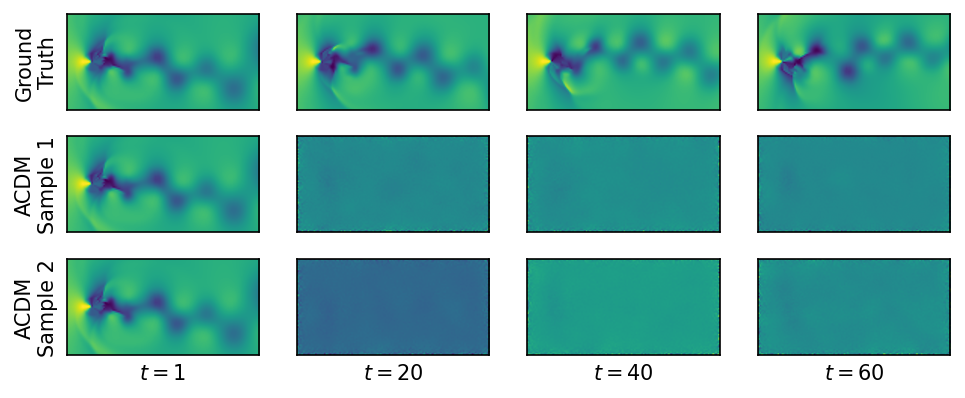

In [16]:
sequence = 0
samples = [0,4]
timeSteps = [0,19,39,59]
field = 3 # velocity_x (0), velocity_y (1), density (2), or pressure (3)

predPart = pred[samples]
gtPred = np.concatenate([gt[:,sequence,timeSteps,field], predPart[:,sequence,timeSteps,field]])

fig, axs = plt.subplots(nrows=gtPred.shape[0], ncols=gtPred.shape[1], figsize=(gtPred.shape[1]*1.9, gtPred.shape[0]), dpi=150, squeeze=False)

for i in range(gtPred.shape[0]):
    for j in range(gtPred.shape[1]):
        if i == gtPred.shape[0]-1:
            axs[i,j].set_xlabel("$t=%s$" % (timeSteps[j]+1), fontsize=10)
        if j == 0:
            if i == 0:
              axs[i,j].set_ylabel("Ground\nTruth", fontsize=10)
            else:
              axs[i,j].set_ylabel("ACDM\nSample %d" % i, fontsize=10)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        im = axs[i,j].imshow(gtPred[i][j].transpose(), interpolation="catrom", cmap="viridis")

plt.show()

## Temporal Stability

Next, we can investigate the temporal stability of the samples by computing a temporal derivative, and comparing the result to the simulation. Note that the result will be smoother, the more sequences and samples are used. Furthermore, better results can be achieved with additional training data. Naturally, the ACDM posterior samples should exhibit a larger variance compared to the individual simulation trajectories.


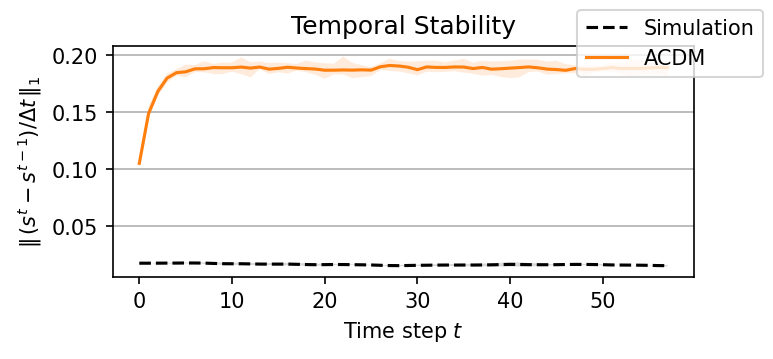

In [17]:
gtTemp = gt[:,:,:,0:4] # ignore scalar Mach number here
predTemp = pred[:,:,:,0:4]

diffGt = np.abs( gtTemp[:,:,1:gtTemp.shape[2]-1] - gtTemp[:,:,2:gtTemp.shape[2]])
diffGt = np.mean(diffGt, axis=(3,4,5)) # channel-wise and spatial mean
minGt = np.min(diffGt, axis=(0,1)) # lower bound over sequences
maxGt = np.max(diffGt, axis=(0,1)) # upper bound over sequences
meanGt = np.mean(diffGt, axis=(0,1)) # sample- and sequence mean

diffPred = np.abs( predTemp[:,:,1:predTemp.shape[2]-1] - predTemp[:,:,2:predTemp.shape[2]])
diffPred = np.mean(diffPred, axis=(3,4,5)) # channel-wise and spatial mean
minPred = np.min(diffPred, axis=(0,1)) # lower bound over samples and sequences
maxPred = np.max(diffPred, axis=(0,1)) # upper bound over samples and sequences
meanPred = np.mean(diffPred, axis=(0,1)) # sample- and sequence mean


fig, ax = plt.subplots(1, figsize=(5,2), dpi=150)
ax.set_title("Temporal Stability")
ax.set_ylabel("$\Vert \, (s^{t} - s^{t-1}) / \Delta t \, \Vert_1$")
ax.yaxis.grid(True)
ax.set_xlabel("Time step $t$")

ax.plot(np.arange(meanGt.shape[0]), meanGt, color="k", label="Simulation", linestyle="dashed")
ax.fill_between(np.arange(meanGt.shape[0]), minGt, maxGt, facecolor="k", alpha=0.15)

ax.plot(np.arange(meanPred.shape[0]), meanPred, color="tab:orange", label="ACDM")
ax.fill_between(np.arange(meanPred.shape[0]), minPred, maxPred, facecolor="tab:orange", alpha=0.15)

fig.legend()
plt.show()

## Spectral Analysis

Finally, let's compute a frequency analysis on a point downstream of the cylinder and compare the spectra of ground truth and ACDM prediction. Note how ACDM matches the simulation both in the low- and high-frequency domain.

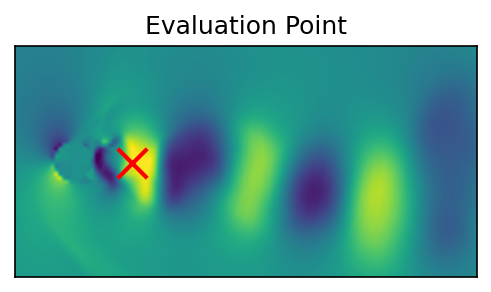

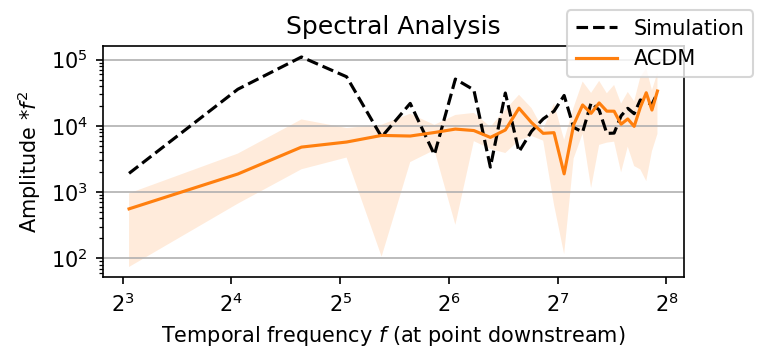

In [18]:
sequence = 0
fracX = 0.25 # closely behing the cylinder
fracY = 0.5 # vertically centered
field = 1 # velocity_x (0), velocity_y (1), density (2), or pressure (3)

posX = int(fracX * gt.shape[4])
posY = int(fracY * gt.shape[5])

gtPred = np.concatenate([gt[:,sequence,:,field, posX, posY], pred[:,sequence,:,field, posX, posY]])

fft = np.fft.fft(gtPred, axis=1)
fft = np.real(fft * np.conj(fft))
n = fft.shape[1]
gridSpacing = 0.002 # delta t between frames from simulation
freq = np.fft.fftfreq(n, d=gridSpacing)[1:int(n/2)]
fft = fft[:,1:int(n/2)] # only use positive fourier frequencies

gtFFT = fft[0]
minPredFFT = np.min(fft[1:], axis=0) # lower bound over samples
maxPredFFT = np.max(fft[1:], axis=0) # upper bound over samples
meanPredFFT = np.mean(fft[1:], axis=0) # sample mean


# plot eval point
fig, ax = plt.subplots(1, figsize=(5,2), dpi=150)
ax.set_title("Evaluation Point")
ax.imshow(gt[0,sequence,0,field].transpose(), interpolation="catrom", cmap="viridis")
ax.scatter(posX, posY, s=200, color="red", marker="x", linewidth=2)
ax.set_xticks([])
ax.set_yticks([])
plt.show()


# plot spectral analysis
fig, ax = plt.subplots(1, figsize=(5,2), dpi=150)
ax.set_title("Spectral Analysis")
ax.set_xlabel("Temporal frequency $f$ (at point downstream)")
ax.set_ylabel("Amplitude $*f^2$")
ax.set_xscale("log", base=2)
ax.set_yscale("log", base=10)
ax.yaxis.grid(True)

ax.plot(freq, gtFFT * (freq**2), color="k", label="Simulation", linestyle="dashed")

ax.plot(freq, meanPredFFT * (freq**2), color="tab:orange", label="ACDM")
ax.fill_between(freq, minPredFFT * (freq**2), maxPredFFT * (freq**2), facecolor="tab:orange", alpha=0.15)

fig.legend()
plt.show()